<a href="https://colab.research.google.com/github/alexandreraisel/Detec-o-de-patologias-em-videiras-utlizando-uma-rede-MobileNet-pre-treinada/blob/master/TrabalhoFinalIA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import seaborn as sns

from sklearn.model_selection import train_test_split

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Nadam, Adam
from keras.utils import to_categorical
from keras.layers import Dropout, Flatten, Input, Dense
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

import random
import tensorflow as tf
import cv2 as cv # utilizado para ler e interpretar imagens
import os # utilizado para manipulação de sistemas de arquivos
import glob # utilizado para procurar arquivos determinados em diretórios 

In [2]:
#Definir os caminhos para o conjunto de dados

black_rot_dir = glob.glob(os.path.join('/content/drive/My Drive/7 semestre/tcc 1/DADOS/Grapes Leaf disease detection/Grapes Leaves Dataset (images)/train/Black_rot/', '*'))
esca_dir = glob.glob(os.path.join('/content/drive/My Drive/7 semestre/tcc 1/DADOS/Grapes Leaf disease detection/Grapes Leaves Dataset (images)/train/Esca_(Black_Measles)/', '*'))
healthy_dir = glob.glob(os.path.join('/content/drive/My Drive/7 semestre/tcc 1/DADOS/Grapes Leaf disease detection/Grapes Leaves Dataset (images)/train/Healthy/', '*'))
leaf_blight_dir = glob.glob(os.path.join('/content/drive/My Drive/7 semestre/tcc 1/DADOS/Grapes Leaf disease detection/Grapes Leaves Dataset (images)/train/Leaf_blight_(Isariopsis_Leaf_Spot)/', '*'))

In [3]:
#Lendo todos os dados de entrada

X_path = black_rot_dir + esca_dir + healthy_dir + leaf_blight_dir
X = []

for f in X_path:
    X.append(np.array(cv.resize(cv.imread(f), (224,224), interpolation = cv.INTER_AREA))) # Normalizar entradas 224 x 224
    
X = np.array(X)

#Normalização dos dados: divisão por 255 já que os valores de cada pixel são RGB variando de 0 à 255.

X = X / 255

In [4]:
#Criação dos rótulos para o treinamento e codificação One-Hot-Encoding

l_black_rot_dir = np.zeros(len(black_rot_dir))
l_black_rot_dir_string = ['black_rot' for i in range(len(black_rot_dir))]
l_esca_dir = np.ones(len(esca_dir))
l_esca_dir_string = ['esca' for i in range(len(esca_dir))]
l_healthy_dir = 2*np.ones(len(healthy_dir))
l_healthy_dir_string = ['healthy' for i in range(len(healthy_dir))]
l_leaf_blight_dir = 3*np.ones(len(leaf_blight_dir))
l_leaf_blight_dir_string = ['leaf_blight' for i in range(len(leaf_blight_dir))]

# concatenar img com rótulos
y_string = np.concatenate((l_black_rot_dir_string, l_esca_dir_string, l_healthy_dir_string, l_leaf_blight_dir_string))
y = np.concatenate((l_black_rot_dir, l_esca_dir, l_healthy_dir, l_leaf_blight_dir))
y = to_categorical(y, 4)

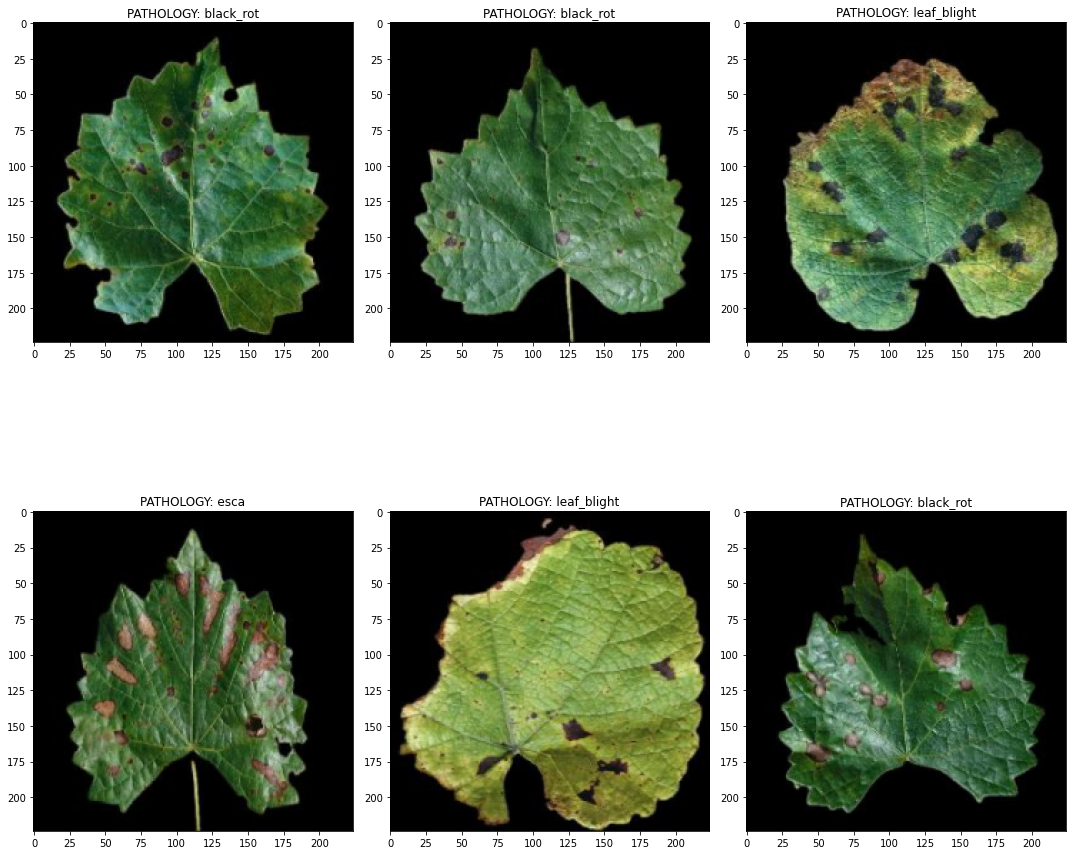

In [5]:
# mostras algumas imagens do conjunto de dados

fig,ax=plt.subplots(2,3)
fig.set_size_inches(15,15)
for i in range(2):
    for j in range (3):
        r = random.randint(0,len(y_string))
        ax[i,j].imshow(X[r][:,:,::-1])
        ax[i,j].set_title('PATHOLOGY: ' + y_string[r])
        
plt.tight_layout()

In [6]:
# Divisão de treinamento e conjuntos de validação
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=42)
X = []

In [7]:
# Data Augmentation
datagen = ImageDataGenerator(
        zoom_range = 0.1, # Zoom aleatorio
        rotation_range= 15, 
        width_shift_range=0.1,  # mudança horizontal
        height_shift_range=0.1,  # mudança vertical
        horizontal_flip=True,  
        vertical_flip=True) 
datagen.fit(X_train)

In [8]:
# Donwload do modelo pré-treinado 
mobileNet = keras.applications.MobileNet(input_shape=(224,224,3), include_top = False, weights= 'imagenet')

In [22]:
#Add de camadas fully-connected

x = mobileNet.output # Saída das camadas convolucionais
x = Flatten()(x) # Prepara vetor para camadas fully-connected
x = Dense(3078,activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1000,activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(256,activation='relu')(x) 
x = Dropout(0.2)(x)
out = Dense(4,activation='softmax')(x) 

tf_model=Model(inputs=mobileNet.input,outputs=out)

In [10]:
# Mosta todas as layers do modelo 
for i,layer in enumerate(tf_model.layers):
    print(i,layer.name)

0 input_1
1 conv1_pad
2 conv1
3 conv1_bn
4 conv1_relu
5 conv_dw_1
6 conv_dw_1_bn
7 conv_dw_1_relu
8 conv_pw_1
9 conv_pw_1_bn
10 conv_pw_1_relu
11 conv_pad_2
12 conv_dw_2
13 conv_dw_2_bn
14 conv_dw_2_relu
15 conv_pw_2
16 conv_pw_2_bn
17 conv_pw_2_relu
18 conv_dw_3
19 conv_dw_3_bn
20 conv_dw_3_relu
21 conv_pw_3
22 conv_pw_3_bn
23 conv_pw_3_relu
24 conv_pad_4
25 conv_dw_4
26 conv_dw_4_bn
27 conv_dw_4_relu
28 conv_pw_4
29 conv_pw_4_bn
30 conv_pw_4_relu
31 conv_dw_5
32 conv_dw_5_bn
33 conv_dw_5_relu
34 conv_pw_5
35 conv_pw_5_bn
36 conv_pw_5_relu
37 conv_pad_6
38 conv_dw_6
39 conv_dw_6_bn
40 conv_dw_6_relu
41 conv_pw_6
42 conv_pw_6_bn
43 conv_pw_6_relu
44 conv_dw_7
45 conv_dw_7_bn
46 conv_dw_7_relu
47 conv_pw_7
48 conv_pw_7_bn
49 conv_pw_7_relu
50 conv_dw_8
51 conv_dw_8_bn
52 conv_dw_8_relu
53 conv_pw_8
54 conv_pw_8_bn
55 conv_pw_8_relu
56 conv_dw_9
57 conv_dw_9_bn
58 conv_dw_9_relu
59 conv_pw_9
60 conv_pw_9_bn
61 conv_pw_9_relu
62 conv_dw_10
63 conv_dw_10_bn
64 conv_dw_10_relu
65 conv_pw_10

In [23]:
# Bloquando o treinamento das camadas convolucionais
for layer in tf_model.layers[:86]:
    layer.trainable=False

In [12]:
tf_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)     

In [25]:
# Definição do otimizador, perda e métricas
tf_model.compile(optimizer = Nadam(0.0001) , loss = 'categorical_crossentropy', metrics=["accuracy"])

In [26]:
#Treinamento do modelo

batch_size = 32
history = tf_model.fit(X_train, y_train, batch_size = 32, epochs = 20, initial_epoch = 0, validation_data = (X_val, y_val))

Epoch 1/20
81/81 [==============================] - 23s 285ms/step - loss: 0.8135 - accuracy: 0.8228 - val_loss: 1.7367 - val_accuracy: 0.7134
Epoch 2/20
81/81 [==============================] - 22s 275ms/step - loss: 0.2744 - accuracy: 0.9396 - val_loss: 0.2436 - val_accuracy: 0.9564
Epoch 3/20
81/81 [==============================] - 22s 275ms/step - loss: 0.1878 - accuracy: 0.9622 - val_loss: 0.0874 - val_accuracy: 0.9766
Epoch 4/20
81/81 [==============================] - 22s 274ms/step - loss: 0.0809 - accuracy: 0.9770 - val_loss: 0.1188 - val_accuracy: 0.9798
Epoch 5/20
81/81 [==============================] - 22s 274ms/step - loss: 0.1102 - accuracy: 0.9797 - val_loss: 0.0954 - val_accuracy: 0.9751
Epoch 6/20
81/81 [==============================] - 22s 274ms/step - loss: 0.0591 - accuracy: 0.9883 - val_loss: 0.0963 - val_accuracy: 0.9766
Epoch 7/20
81/81 [==============================] - 22s 275ms/step - loss: 0.0448 - accuracy: 0.9871 - val_loss: 0.0885 - val_accuracy: 0.9844

In [15]:
#tf_model.save('/content/drive/My Drive/7 semestre/tcc 1/DADOS/Modelo salvo/versaoBeta2108.h5')
#model = keras.models.load_model('/content/drive/My Drive/7 semestre/tcc 1/DADOS/Modelo salvo/versaoBeta.h5')

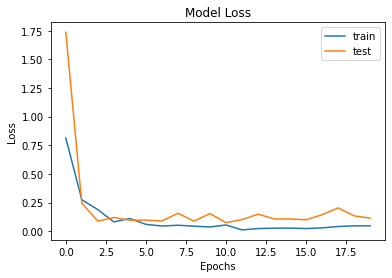

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

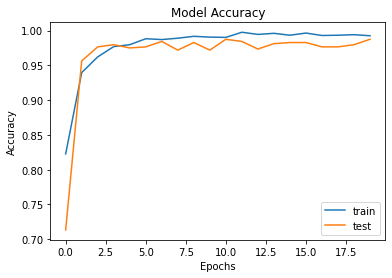

In [28]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

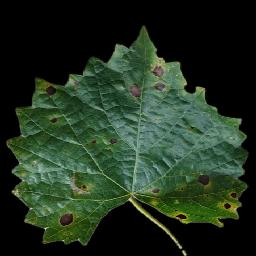

In [17]:
from IPython.display import Image

Image(filename='/content/drive/My Drive/7 semestre/tcc 1/DADOS/Grapes Leaf disease detection/Grapes Leaves Dataset (images)/test/Black_rot/003d09ef-e16c-4e8a-badf-847d46cb3dc0___FAM_B.Rot 3184_final_masked.jpg')


In [18]:
from keras.preprocessing import image

def load_image(img_path, show=False):

    img = image.load_img(img_path, target_size=(224, 224))
    img_tensor = image.img_to_array(img)                    # (altura, largura, canais)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, altura, largura, canais), adiciona uma dimensão porque o modelo espera esta forma: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow espera valores no intervalo [0, 1]


    return img_tensor
  
img_path = '/content/drive/My Drive/7 semestre/tcc 1/DADOS/Grapes Leaf disease detection/Grapes Leaves Dataset (images)/test/Black_rot/003d09ef-e16c-4e8a-badf-847d46cb3dc0___FAM_B.Rot 3184_final_masked.jpg'
new_image = load_image(img_path)

pred = tf_model.predict(new_image)[0]

if(np.argmax(pred)==0):
  print('Black_rot',pred[0]*100)
elif(np.argmax(pred)==1):
  print('Esca',pred[1]*100)
elif(np.argmax(pred)==2):
  print('Healthy',pred[2]*100)
else:
  print('Leaf_blight',pred[3]*100)


Black_rot 100.0


In [29]:
eval_datagen = datagen.flow(
        X_val, y_val,
        batch_size=batch_size,
        shuffle=False)      # since shuffle was already during splitting into train, valid, test

import seaborn as sns
from sklearn import metrics

pred = tf_model.predict(eval_datagen, verbose=1)

# get most likely class
y_pred = pred.argmax(axis=1)
y_true = y_val.argmax(axis=1)

print(metrics.classification_report(y_true, y_pred))

21/21 [==============================] - 8s 359ms/step
              precision    recall  f1-score   support

           0       0.94      0.90      0.92       215
           1       0.96      0.85      0.90       223
           2       0.84      0.98      0.90        48
           3       0.85      1.00      0.92       156

    accuracy                           0.91       642
   macro avg       0.90      0.93      0.91       642
weighted avg       0.92      0.91      0.91       642



Text(0.5, 33.0, 'Predicted label')

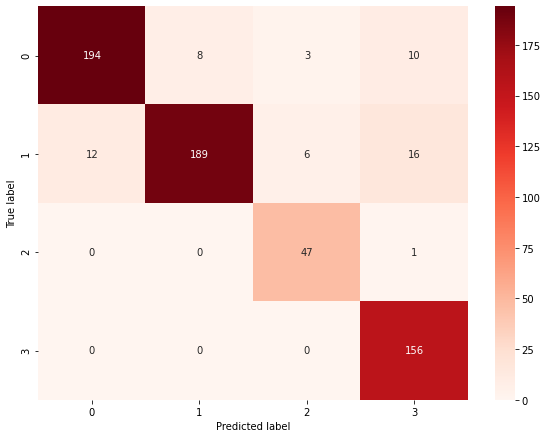

In [30]:
# confusion matrix

labels = ({0:'black_rot',1:'esca',2:'healthy',3:'leaf_blight'})

mat = metrics.confusion_matrix(y_true, y_pred)
df_mat = pd.DataFrame(mat, index=labels, columns=labels)
plt.figure(figsize=(8,6))
sns.heatmap(df_mat, annot=True, fmt='d', cmap=plt.cm.Reds)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')